In [14]:
import torch
import gpytorch
import math
from matplotlib import pyplot as plt
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
lb, ub = 0.0, 5*math.pi

train_x = torch.linspace(lb, ub, 100).unsqueeze(-1)
train_y = torch.stack([
    torch.sin(2*train_x) + torch.cos(train_x), 
    -torch.sin(train_x) + 2*torch.cos(2*train_x)
], -1).squeeze(1)

In [20]:
class GPModelWithDerivatives(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(GPModelWithDerivatives, self).__init__(train_x, train_y, likelihood)
        self.mean_module = gpytorch.means.ConstantMeanGrad()
        self.covar_module = gpytorch.kernels.RBFKernelGrad()

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultitaskMultivariateNormal(mean_x, covar_x)

    
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=2)
model = GPModelWithDerivatives(train_x, train_y, likelihood)

In [21]:
# Find optimal model hyperparameters
model.train()
likelihood.train()

# Use the adam optimizer
optimizer = torch.optim.Adam([
    {'params': model.parameters()},  # Includes GaussianLikelihood parameters
], lr=0.1)

# "Loss" for GPs - the marginal log likelihood
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

n_iter = 50
for i in range(n_iter):
    optimizer.zero_grad()
    output = model(train_x)
    loss = -mll(output, train_y)
    loss.backward()
    print('Iter %d/%d - Loss: %.3f' % (i + 1, n_iter, loss.item()))
    optimizer.step()

Iter 1/50 - Loss: 128.564
Iter 2/50 - Loss: 123.239
Iter 3/50 - Loss: 119.471
Iter 4/50 - Loss: 114.999
Iter 5/50 - Loss: 111.768
Iter 6/50 - Loss: 108.339
Iter 7/50 - Loss: 105.248
Iter 8/50 - Loss: 100.716
Iter 9/50 - Loss: 97.057
Iter 10/50 - Loss: 94.148
Iter 11/50 - Loss: 91.176
Iter 12/50 - Loss: 86.638
Iter 13/50 - Loss: 80.966
Iter 14/50 - Loss: 77.911
Iter 15/50 - Loss: 72.931
Iter 16/50 - Loss: 70.648
Iter 17/50 - Loss: 66.616
Iter 18/50 - Loss: 63.672
Iter 19/50 - Loss: 56.317
Iter 20/50 - Loss: 49.783
Iter 21/50 - Loss: 48.089
Iter 22/50 - Loss: 47.358
Iter 23/50 - Loss: 41.717
Iter 24/50 - Loss: 33.350
Iter 25/50 - Loss: 29.555
Iter 26/50 - Loss: 24.426
Iter 27/50 - Loss: 25.261
Iter 28/50 - Loss: 18.025
Iter 29/50 - Loss: 13.513
Iter 30/50 - Loss: 9.686
Iter 31/50 - Loss: 4.416
Iter 32/50 - Loss: -0.345
Iter 33/50 - Loss: -5.136
Iter 34/50 - Loss: -12.027
Iter 35/50 - Loss: -16.741
Iter 36/50 - Loss: -20.538
Iter 37/50 - Loss: -27.107
Iter 38/50 - Loss: -28.344
Iter 39/50

## Predicting on 200 test points: Gradient looks weird for last 100 points

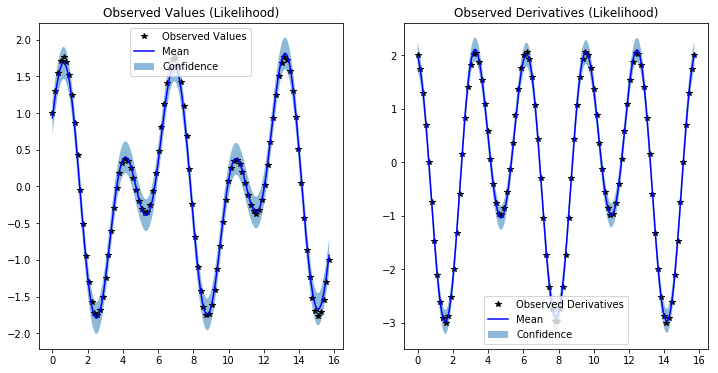

In [23]:
# Set into eval mode
model.eval()
likelihood.eval()

# Initialize plots
f, (y1_ax, y2_ax) = plt.subplots(1, 2, figsize=(12, 6))

# Make predictions
with torch.no_grad(), gpytorch.fast_pred_var():
    test_x = torch.linspace(lb, ub, 10000)
    predictions = likelihood(model(test_x))
    mean = predictions.mean
    lower, upper = predictions.confidence_region()
    
# Plot training data as black stars
y1_ax.plot(train_x.detach().numpy(), train_y[:, 0].detach().numpy(), 'k*')
# Predictive mean as blue line
y1_ax.plot(test_x.numpy(), mean[:, 0].numpy(), 'b')
# Shade in confidence 
y1_ax.fill_between(test_x.numpy(), lower[:, 0].numpy(), upper[:, 0].numpy(), alpha=0.5)
y1_ax.legend(['Observed Values', 'Mean', 'Confidence'])
y1_ax.set_title('Observed Values (Likelihood)')

# Plot training data as black stars
y2_ax.plot(train_x.detach().numpy(), train_y[:, 1].detach().numpy(), 'k*')
# Predictive mean as blue line
y2_ax.plot(test_x.numpy(), mean[:, 1].numpy(), 'b')
# Shade in confidence 
y2_ax.fill_between(test_x.numpy(), lower[:, 1].numpy(), upper[:, 1].numpy(), alpha=0.5)
y2_ax.legend(['Observed Derivatives', 'Mean', 'Confidence'])
y2_ax.set_title('Observed Derivatives (Likelihood)')

None